# Further inspection of recordings showed a third frequency group

#### Before taking more sophisticated approaches towards frequency-based clustering, I felt it would be good to establish a few example recordings represetative of the kinds of frequencies I have observed.

In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

In [2]:
import sys

sys.path.append("../src")

In [3]:
from core import SITE_NAMES, FREQ_GROUPS, EXAMPLE_FILES_from_LOCATIONS, EXAMPLE_FILES_to_FILEPATHS, EXAMPLE_FILES_to_DETECTIONS
import bout_clustering as bt_clustering
import bout_plotting as bt_plt
import subsampling as ss
import data_handling as dh

from cli import get_file_paths

In [4]:
site_key = 'Central'
freq_key = ''

bout_params = dict()
bout_params['site_key'] = site_key
bout_params['freq_key'] = freq_key

fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
fig_details['freq_group'] = freq_key.split('_')[0].upper()
if freq_key:
    fig_details['freq_group'] = fig_details['freq_group'] + ' '
fig_details['bin_step'] = 10
fig_details['time_end'] = 2000
print(f'Looking at {fig_details["site_name"]}')

Looking at Central Pond


### Below, red and yellow detections were both originally clustered together as HF calls.
### Blue detections were originally clustered together as LF calls

#### **A white dashed line has been included to show a potential frequency threshold to separate the yellow and red group.**
#### **Calls with min. frequency >= 43000 have been put into the yellow group.**
#### **As an update to the previous notebook, calls with min. frequency >= 35000 have been put into the red group**

In [119]:
def plot_det_groups_over_audio_seg(audio_features, spec_features, plot_dets, plot_region):
    """
    Function to plot the spectrogram of a provided audio segment with overlayed detections
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    blue_l_bound = 18000
    blue_u_bound = 46000

    red_l_bound = 34000
    red_u_bound = 74000

    yellow_l_bound = 42000
    yellow_u_bound = 92000

    plt.figure(figsize=(15, 7))
    plt.rcParams.update({'font.size': 24})
    plt.title(f"BatDetect2 detections on {audio_features['file_path'].name}", fontsize=22)
    plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])
    if plot_region == 'yellow':
        plt.fill_between(x=np.linspace(0, duration*(fs/2), 11), y1=yellow_l_bound/(fs/2), y2=yellow_u_bound/(fs/2), color='yellow', linewidth=2, alpha=0.5)
    if plot_region == 'red':
        plt.fill_between(x=np.linspace(0, duration*(fs/2), 11), y1=red_l_bound/(fs/2), y2=red_u_bound/(fs/2), color='red', linewidth=2, alpha=0.5)
    if plot_region == 'blue':
        plt.fill_between(x=np.linspace(0, duration*(fs/2), 11), y1=blue_l_bound/(fs/2), y2=blue_u_bound/(fs/2), color='cyan', linewidth=2, alpha=0.5)
    yellow_patch = patches.Patch(facecolor='yellow', edgecolor='k', label='Group 1')
    red_patch = patches.Patch(facecolor='red', edgecolor='k', label='Group 2')
    blue_patch = patches.Patch(facecolor='cyan', edgecolor='k', label='Group 3')
    legend_patches = [yellow_patch, red_patch, blue_patch]
    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        if row['low_freq'] >= yellow_l_bound and row['high_freq'] <= yellow_u_bound:
            rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                            (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                            linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
        elif row['low_freq'] >= red_l_bound and row['high_freq'] <= red_u_bound:
            rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                            (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                            linewidth=2, edgecolor='red', facecolor='none', alpha=0.8)
        elif row['low_freq'] >= blue_l_bound and row['high_freq'] <= blue_u_bound:
            rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                            (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                            linewidth=2, edgecolor='cyan', facecolor='none', alpha=0.8)
        else:
            rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                            (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                            linewidth=2, edgecolor='yellowgreen', facecolor='none', alpha=0.8)
        ax.add_patch(rect)
    plt.yticks(ticks=np.linspace(0, 1, 11), labels=np.linspace(0, fs/2000, 11).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.gcf().autofmt_xdate()
    plt.legend(handles=legend_patches, fontsize=20, ncol=int(len(legend_patches)), loc='upper right')

    plt.tight_layout()
    plt.show()

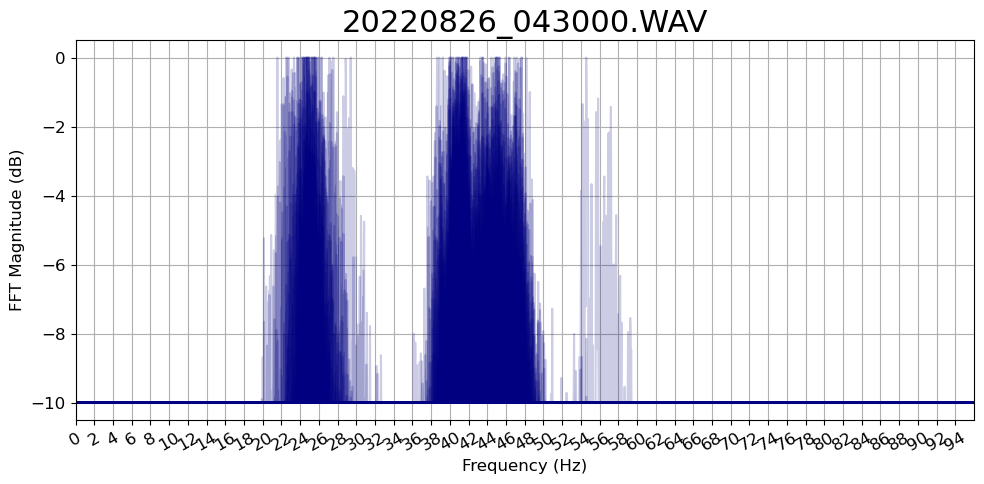

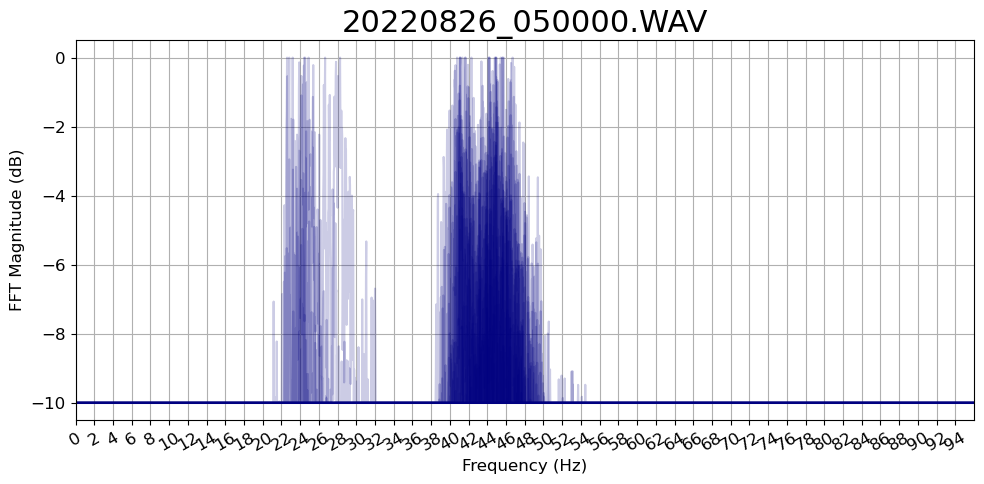

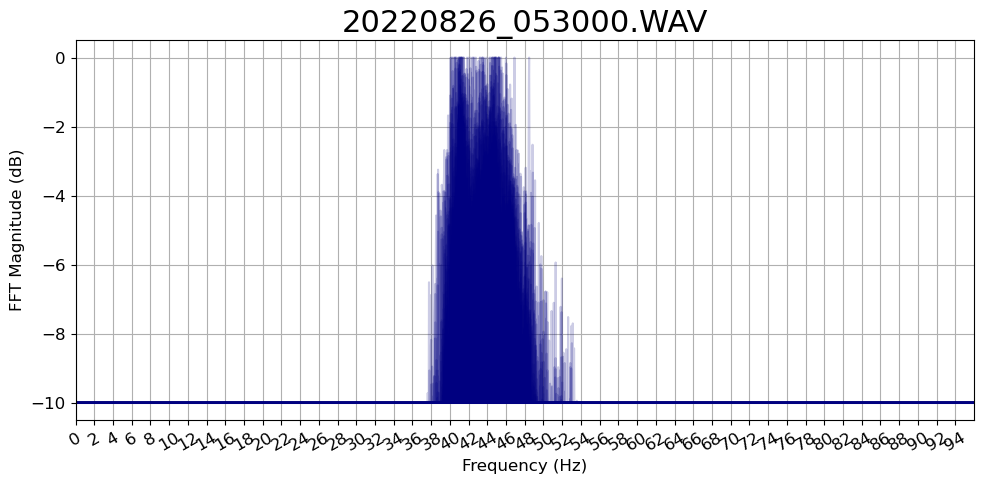

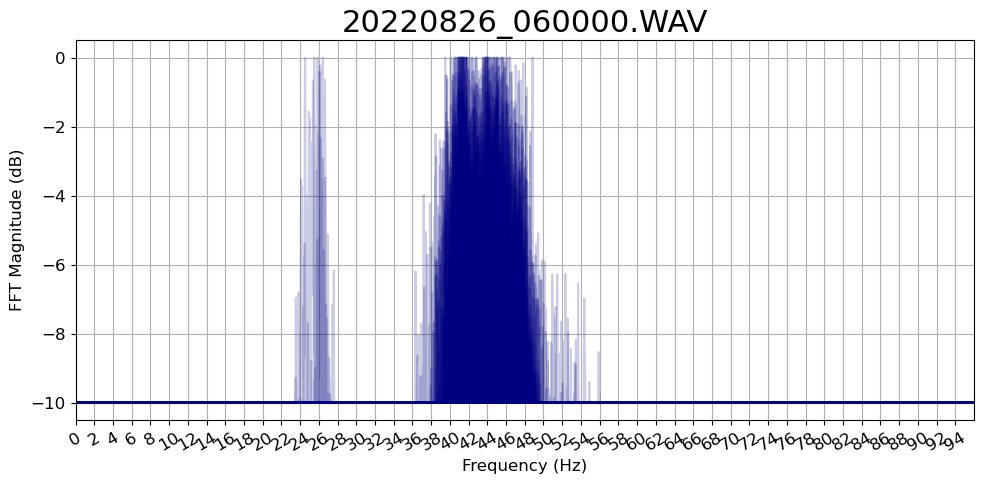

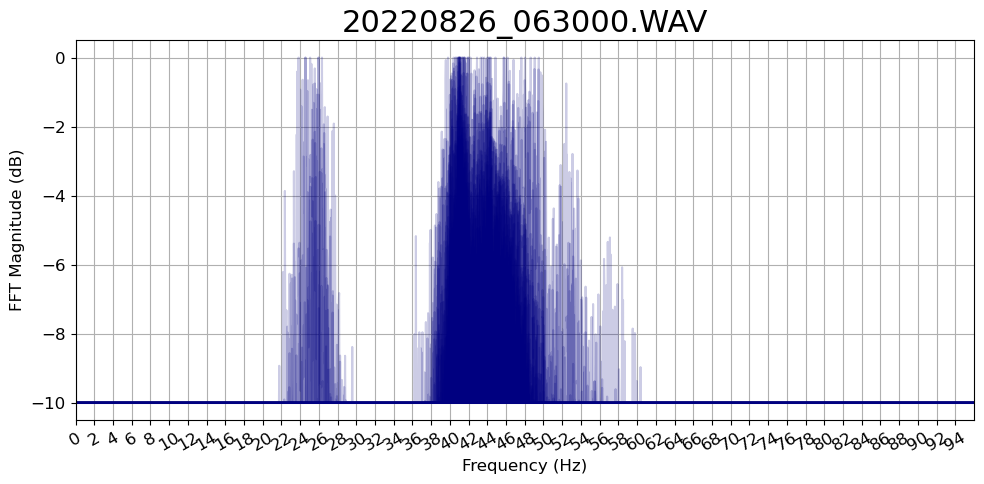

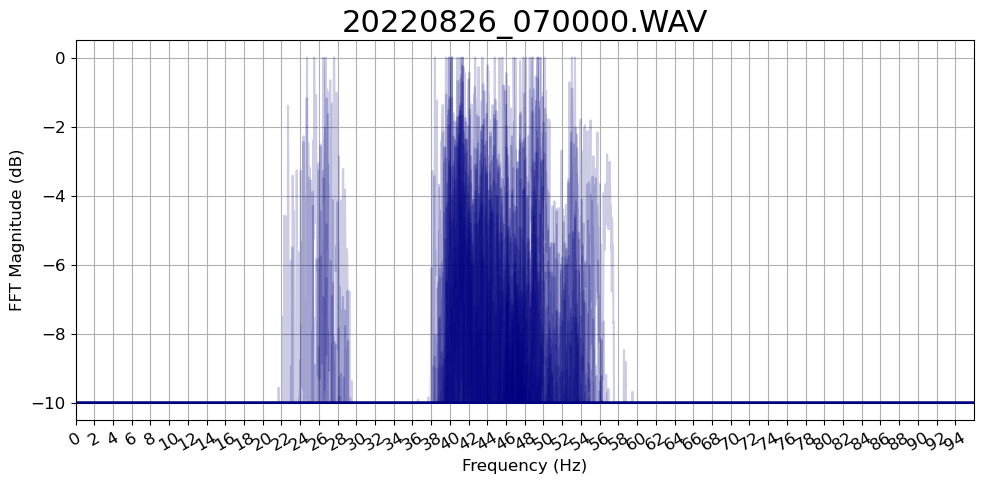

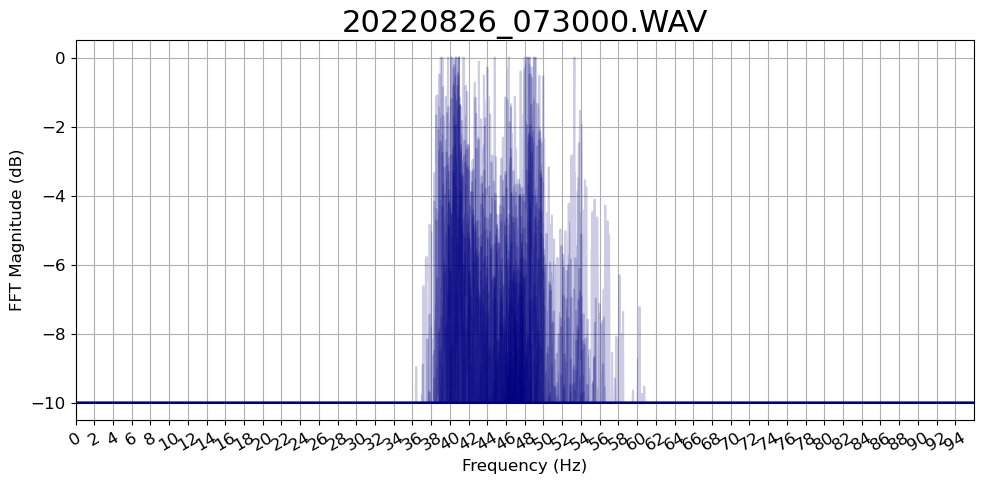

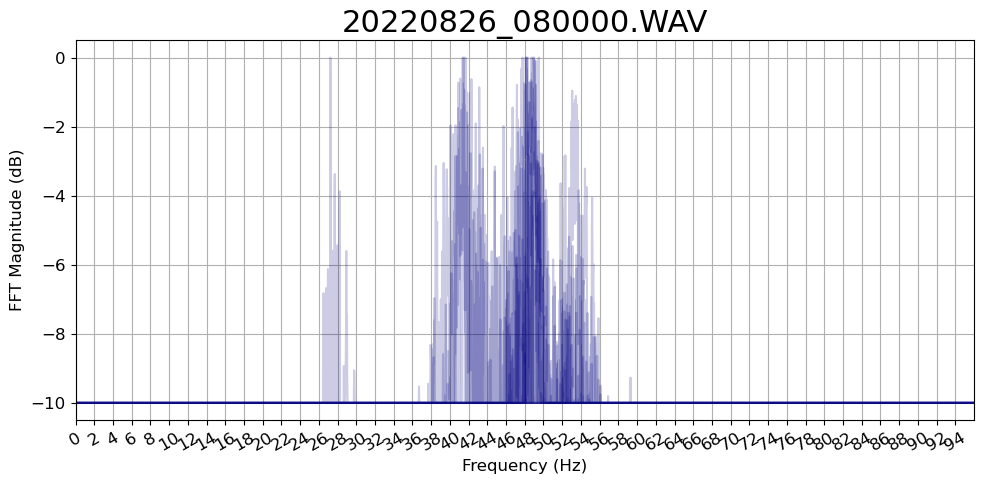

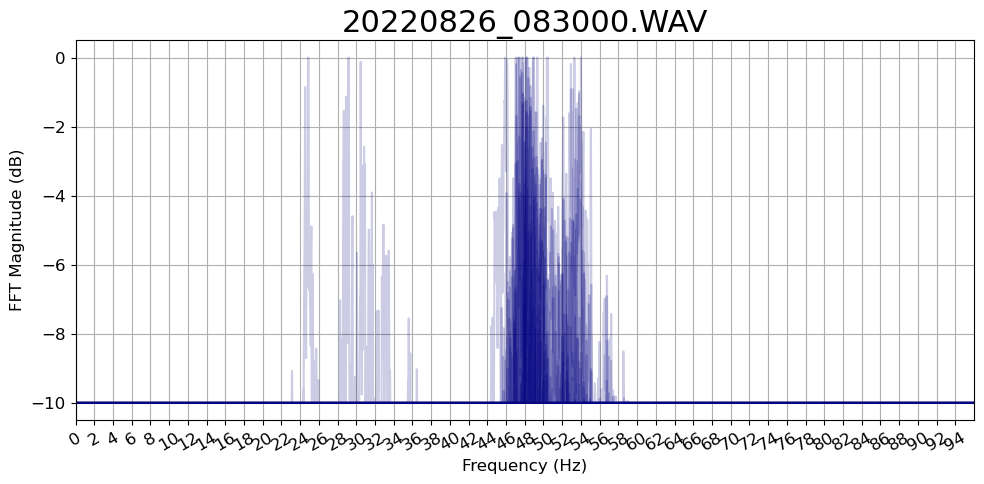

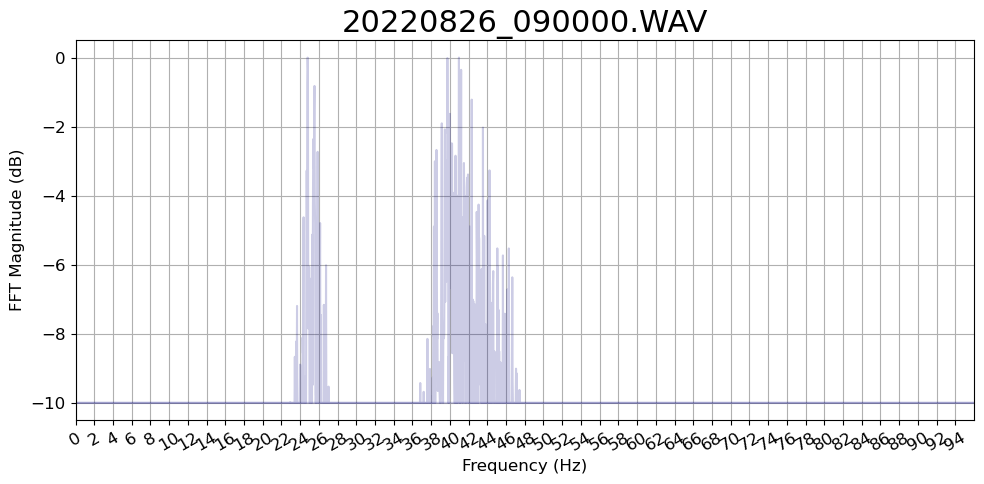

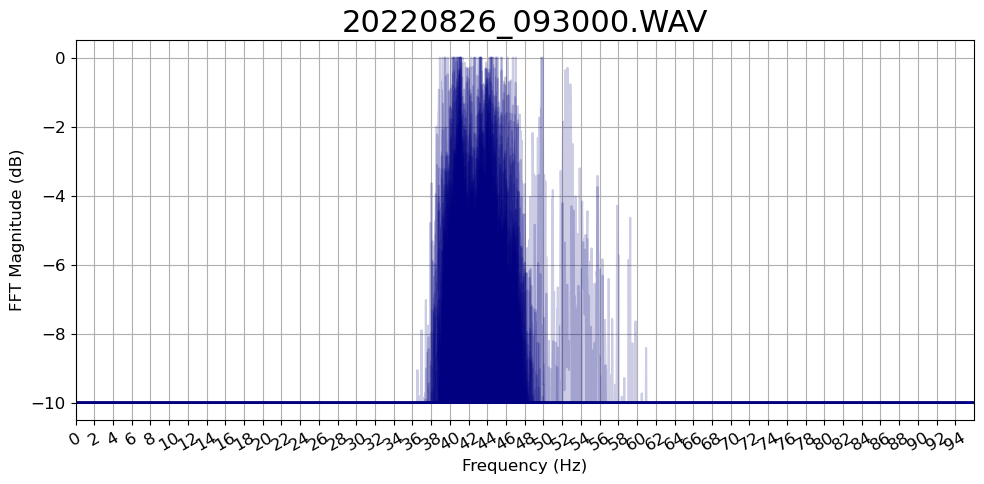

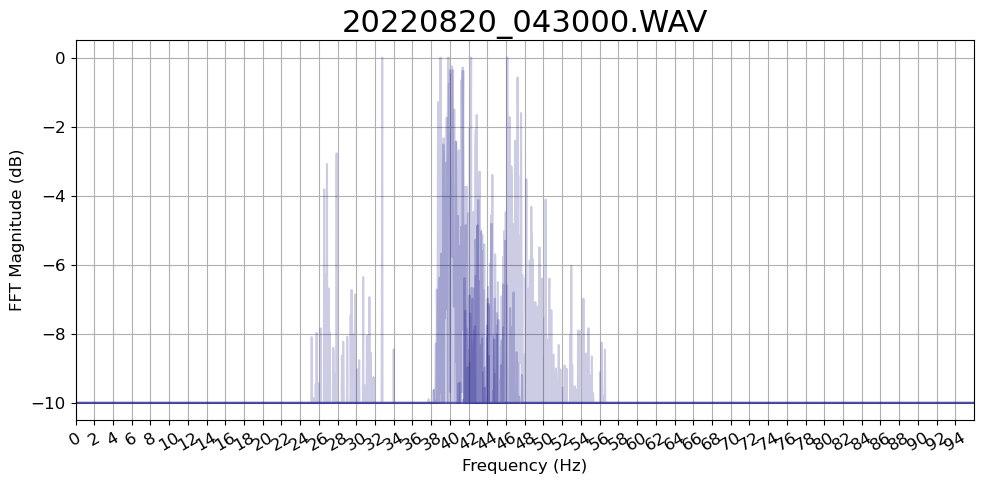

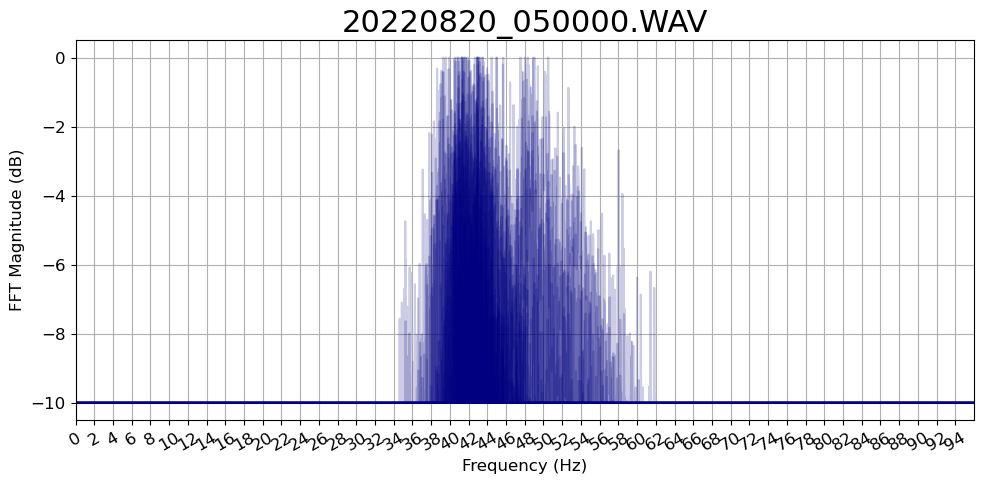

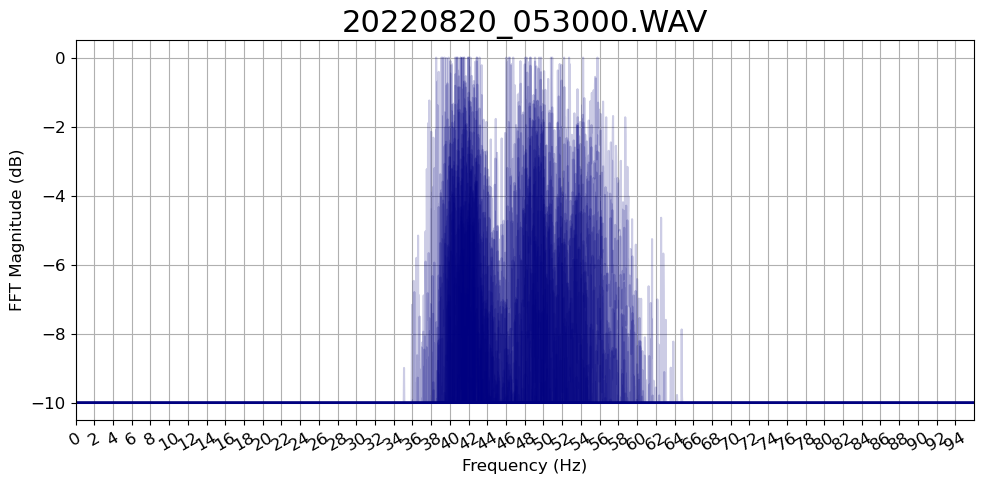

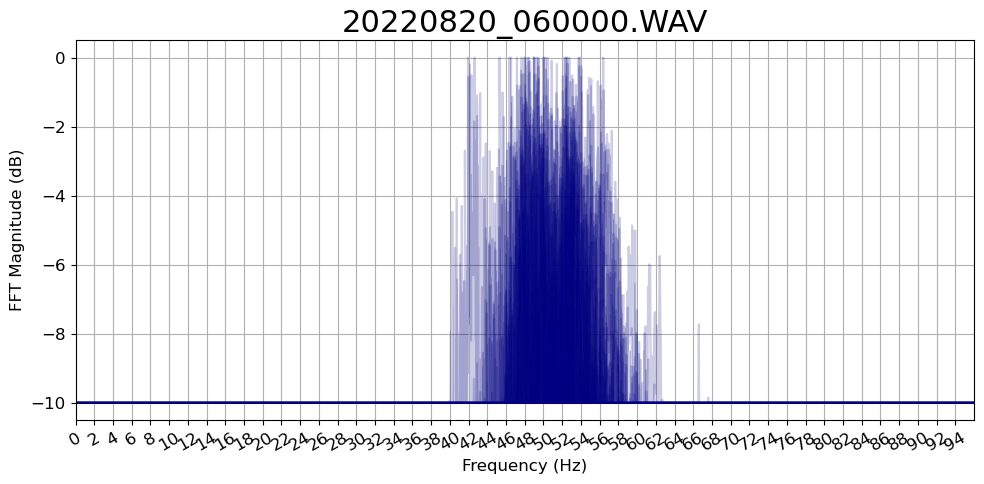

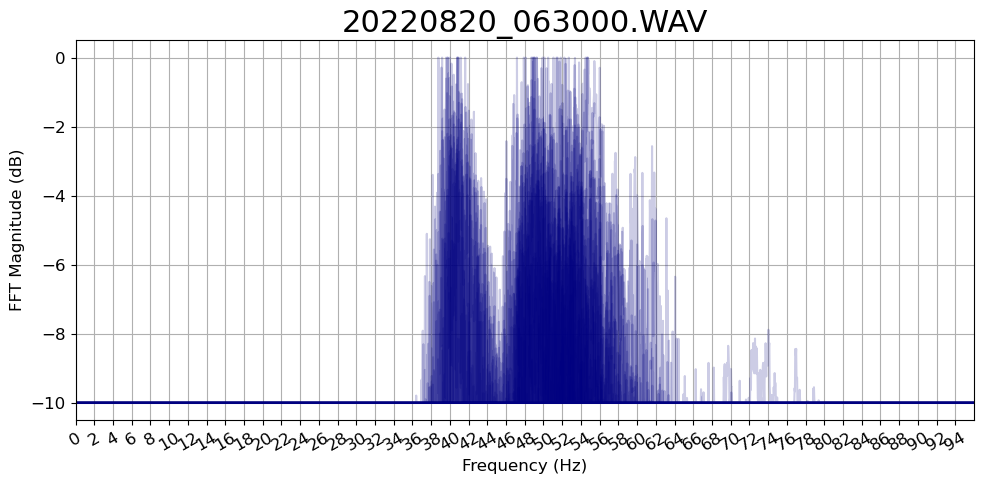

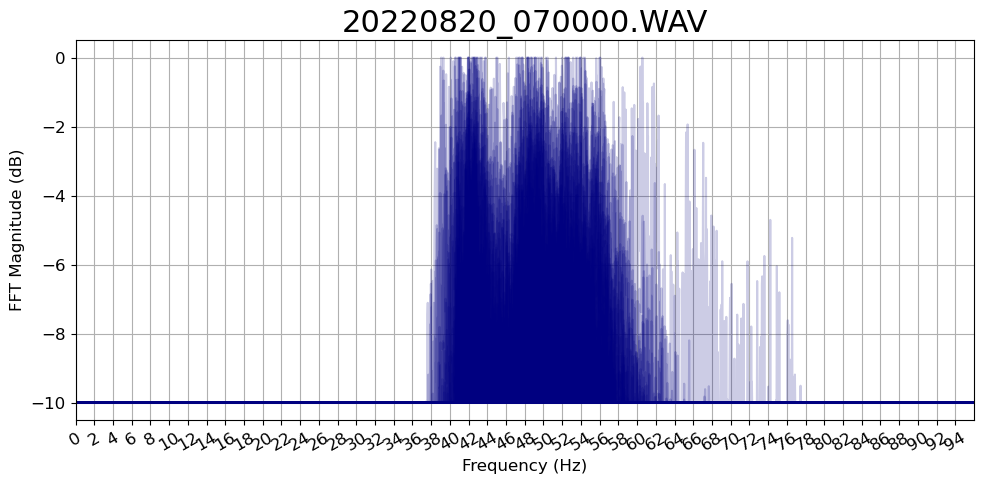

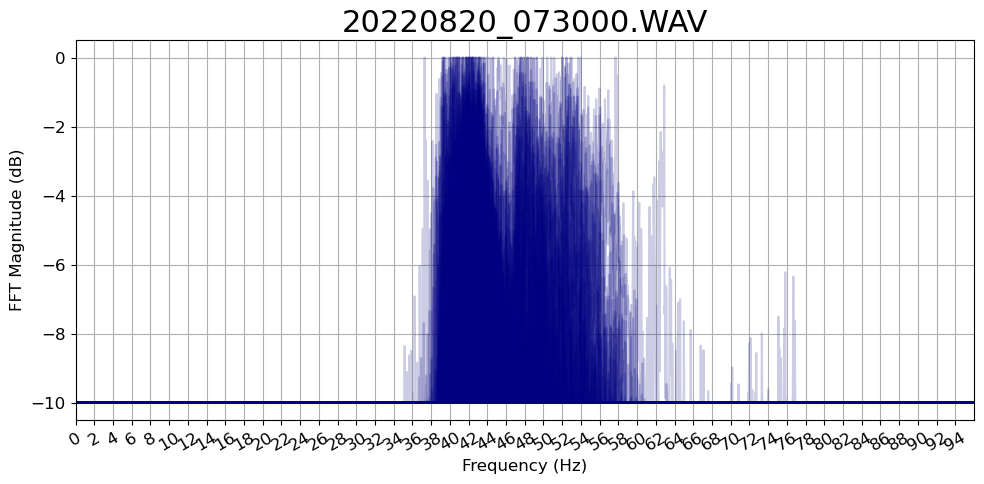

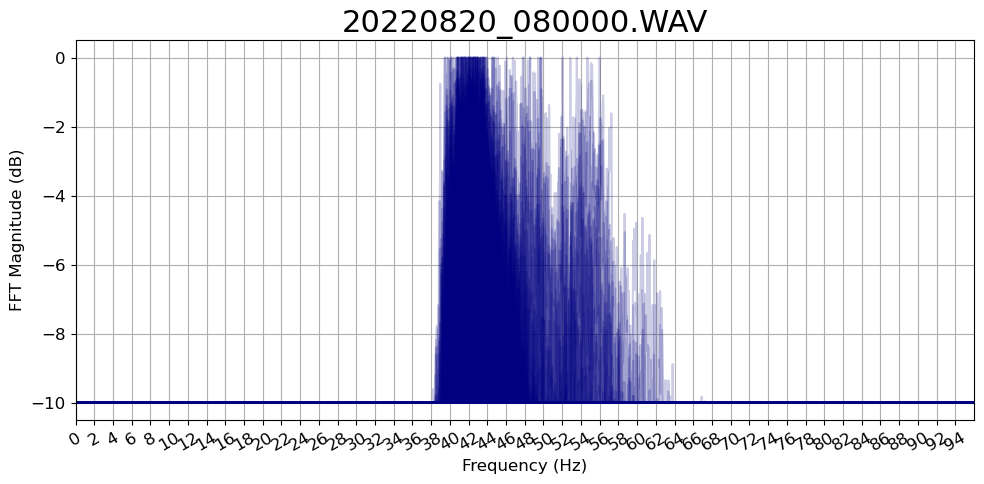

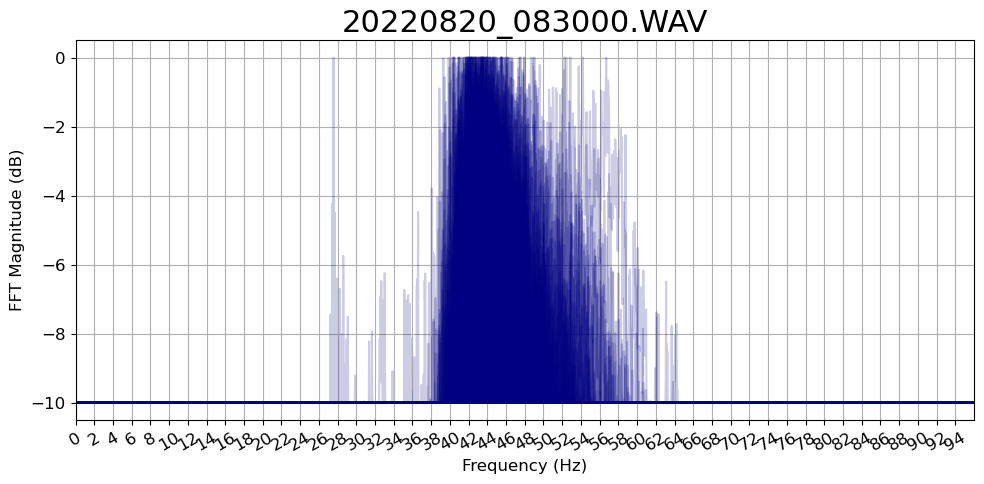

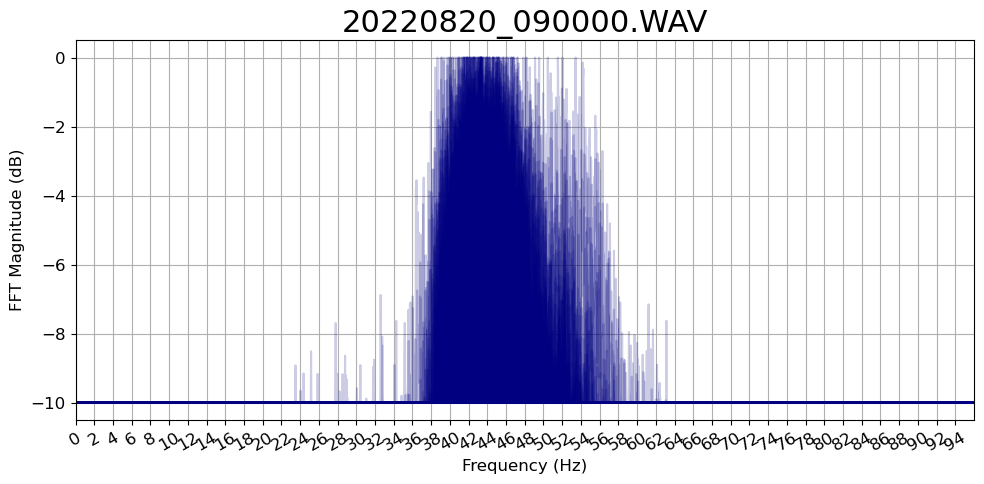

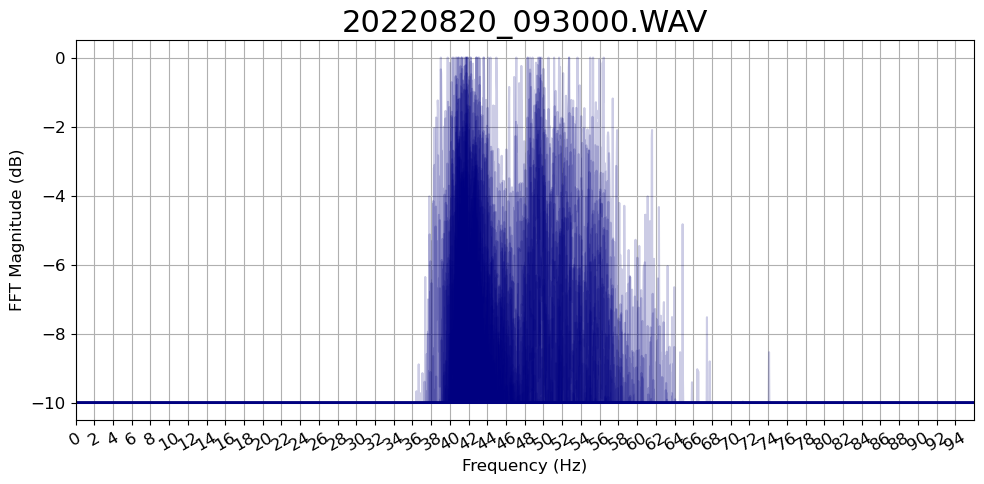

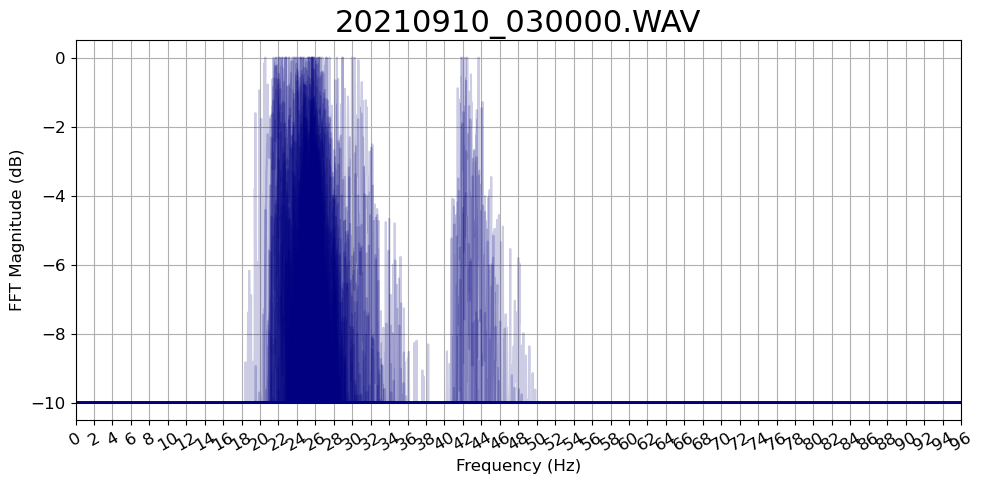

In [35]:
for filepath_key in EXAMPLE_FILES_to_FILEPATHS.keys():
    filename = filepath_key.split('/')[-1]
    reduce = 55
    file_path = Path(EXAMPLE_FILES_to_FILEPATHS[filepath_key])
    audio_file = sf.SoundFile(file_path)
    fs = audio_file.samplerate

    data_params = dict()
    data_params['freq_tags'] = FREQ_GROUPS[bout_params['freq_key']]
    spec_features = dict()
    spec_features['NFFT'] = 1024
    spec_features['cmap'] = 'jet'
    csv_path = Path(EXAMPLE_FILES_to_DETECTIONS[filepath_key])
    batdetect2_predictions = dh.assemble_single_bd2_output(csv_path, data_params)
    freq_key = ''
    selected_calls = batdetect2_predictions.loc[(batdetect2_predictions['low_freq']>=FREQ_GROUPS[freq_key][0])&(batdetect2_predictions['high_freq']<=FREQ_GROUPS[freq_key][1])]

    plt.figure(figsize=(10, 5))
    ft_size = 12
    plt.rcParams.update({'font.size':ft_size})
    plt.title(f"{filename}.WAV", fontsize=ft_size+10)
    thresh = -10
    line_color = 'navy'
    line_alpha = 0.2

    for i, row in selected_calls[::50].iterrows():

        ########################################################################################################
        ############### BELOW WE READ IN THE WINDOW OF DETECTION OF THE AUDIO WE ARE CONSIDERING ###############
        ########################################################################################################

        start = row['start_time'] - 0.01
        end = row['start_time'] + 0.02
        duration = end - start
        audio_file.seek(int(fs*start))
        audio_seg = audio_file.read(int(fs*duration))

        ################################################################################################
        ############### BELOW WE APPLY A BANDPASS FILTER ON THE AUDIO WE ARE CONSIDERING ###############
        ################################################################################################

        nyq = 0.5 * fs
        low_cutoff = (row['low_freq'] - 2000) / nyq
        high_cutoff =  (row['high_freq'] + 2000) / nyq

        if (row['high_freq'] + 2000 < fs/2):

            b, a = scipy.signal.butter(5, [low_cutoff, high_cutoff], btype='band', analog=False)
            plot_audio_seg = scipy.signal.filtfilt(b, a, audio_seg)

            #####################################################################################
            ############### BELOW WE PLOT THE FFT OF THE AUDIO WE ARE CONSIDERING ###############
            #####################################################################################

            audio_spectrum = scipy.fft.rfft(plot_audio_seg)
            audio_spectrum_abs = np.abs(audio_spectrum)
            frequencies = np.arange(0, len(audio_spectrum_abs))
            audio_spectrum_db =  20*np.log10(audio_spectrum_abs)
            normalized_audio_spectrum_db = audio_spectrum_db - audio_spectrum_db.max()

            thresh = -10
            peak_db = np.zeros(len(normalized_audio_spectrum_db))+thresh
            peak_db[normalized_audio_spectrum_db>=thresh] = normalized_audio_spectrum_db[normalized_audio_spectrum_db>=thresh]
            
            plt.plot(frequencies, peak_db, color=line_color, alpha=line_alpha)
        
    plot_x_ticks = np.arange(0, duration*(fs/2), duration*2000)
    plt.xticks(ticks=plot_x_ticks, labels=np.arange(0, fs/2000, 2, dtype='int'), rotation=30)
    plt.xlim((0)*duration, (96000)*duration)
    plt.ylabel("FFT Magnitude (dB)")
    plt.xlabel("Frequency (Hz)")
    plt.grid(which='both')
    plt.tight_layout()
    plt.show()

In [125]:
def plot_call_sig_window(audio_features):
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    plt.figure(figsize=(4.5, 4.5))
    ft_size = 18
    plt.rcParams.update({'font.size': ft_size})
    plt.title(f"{audio_features['file_path'].name}", fontsize=ft_size-2)
    plt.plot(audio_seg)
    plt.xticks(ticks=np.linspace(0, duration*fs, 4), labels=np.round(np.linspace(start, start+duration, 4, dtype='float'), 2), rotation=30)
    plt.xlim(0, duration*fs)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.grid(which='both')
    plt.tight_layout()
    plt.show()


def plot_call_spec_window(audio_features, spec_features, row):
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    plt.figure(figsize=(4.5, 4.5))
    ft_size = 18
    plt.rcParams.update({'font.size': ft_size})
    plt.title(f"{audio_features['file_path'].name}", fontsize=ft_size-2)
    plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])
    ax = plt.gca()

    row = batdetect2_predictions.iloc[i]
    rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=4, edgecolor='yellow', facecolor='none', alpha=0.8)
    ax.add_patch(rect)

    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 4), labels=np.round(np.linspace(start, start+duration, 4, dtype='float'), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")

    plt.tight_layout()
    plt.show()

In [126]:
freq_key = ''
selected_calls = batdetect2_predictions.loc[(batdetect2_predictions['low_freq']>=FREQ_GROUPS[freq_key][0])&(batdetect2_predictions['high_freq']<=FREQ_GROUPS[freq_key][1])]

In [127]:
selected_calls = selected_calls.reset_index()
selected_calls.drop(columns=selected_calls.columns[0], inplace=True)
selected_calls

,ref_time,call_start_time,call_end_time,start_time,end_time,low_freq,high_freq,class,class_prob,det_prob,individual,event,input_file,Recover Folder,SD Card,Site name
0,2022-08-26 07:00:03.770500,2022-08-26 07:00:03.770500,2022-08-26 07:00:03.777100000,3.7705,3.7771,45234.0,54096.0,Pipistrellus pipistrellus,0.466,0.512,-1,Echolocation,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,recover-20220828,UBNA_010,Central Pond
1,2022-08-26 07:00:04.308500,2022-08-26 07:00:04.308500,2022-08-26 07:00:04.314000000,4.3085,4.3140,46093.0,59238.0,Pipistrellus pipistrellus,0.512,0.542,-1,Echolocation,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,recover-20220828,UBNA_010,Central Pond
2,2022-08-26 07:00:04.850500,2022-08-26 07:00:04.850500,2022-08-26 07:00:04.855800000,4.8505,4.8558,45234.0,62030.0,Pipistrellus pipistrellus,0.427,0.524,-1,Echolocation,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,recover-20220828,UBNA_010,Central Pond
3,2022-08-26 07:00:05.003500,2022-08-26 07:00:05.003500,2022-08-26 07:00:05.009400000,5.0035,5.0094,45234.0,60073.0,Pipistrellus pipistrellus,0.489,0.538,-1,Echolocation,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,recover-20220828,UBNA_010,Central Pond
4,2022-08-26 07:00:05.151500,2022-08-26 07:00:05.151500,2022-08-26 07:00:05.156900000,5.1515,5.1569,46093.0,61459.0,Pipistrellus pipistrellus,0.439,0.517,-1,Echolocation,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,recover-20220828,UBNA_010,Central Pond
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1592,2022-08-26 07:29:47.774500,2022-08-26 07:29:47.774500,2022-08-26 07:29:47.784900000,1787.7745,1787.7849,37500.0,46675.0,Pipistrellus nathusii,0.492,0.587,-1,Echolocation,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,recover-20220828,UBNA_010,Central Pond
1593,2022-08-26 07:29:47.959500,2022-08-26 07:29:47.959500,2022-08-26 07:29:47.969400000,1787.9595,1787.9694,37500.0,45913.0,Pipistrellus nathusii,0.537,0.591,-1,Echolocation,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,recover-20220828,UBNA_010,Central Pond
1594,2022-08-26 07:29:48.212500,2022-08-26 07:29:48.212500,2022-08-26 07:29:48.221200000,1788.2125,1788.2212,39218.0,48186.0,Pipistrellus nathusii,0.431,0.544,-1,Echolocation,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,recover-20220828,UBNA_010,Central Pond
1595,2022-08-26 07:29:48.413500,2022-08-26 07:29:48.413500,2022-08-26 07:29:48.422500000,1788.4135,1788.4225,40078.0,49982.0,Pipistrellus nathusii,0.441,0.566,-1,Echolocation,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,recover-20220828,UBNA_010,Central Pond


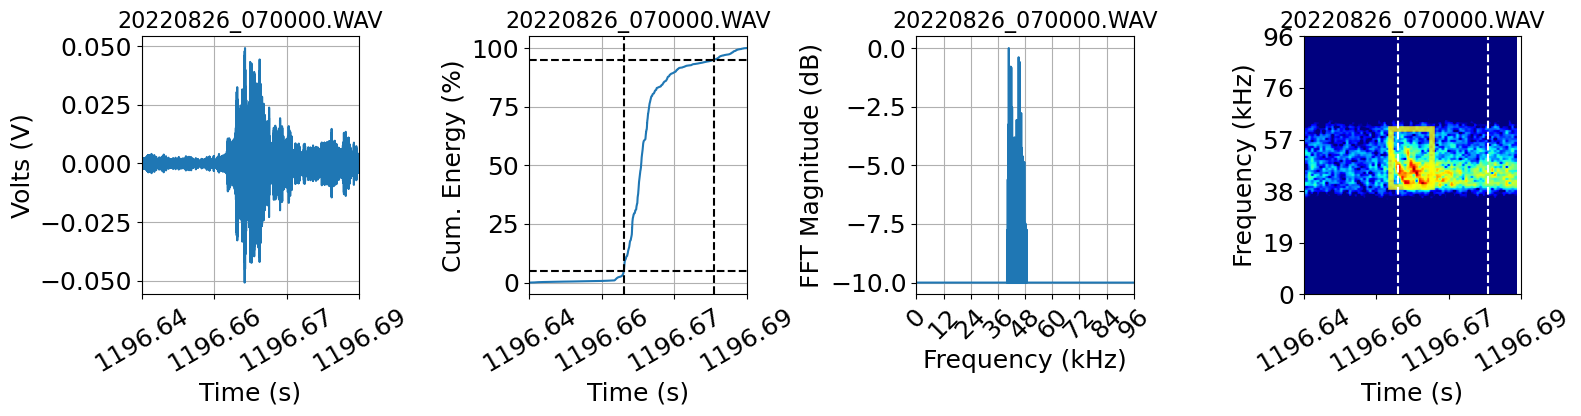

In [131]:
i = np.random.randint(len(selected_calls))
row = selected_calls.iloc[i]

########################################################################################################
############### BELOW WE READ IN THE WINDOW OF DETECTION OF THE AUDIO WE ARE CONSIDERING ###############
########################################################################################################

start = row['start_time'] - 0.02
end = row['start_time'] + 0.03
duration = end - start
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
spec_features['NFFT'] = 256
spec_features['cmap'] = 'jet'

################################################################################################
############### BELOW WE APPLY A BANDPASS FILTER ON THE AUDIO WE ARE CONSIDERING ###############
################################################################################################

nyq = 0.5 * fs
low_cutoff = (row['low_freq'] - 2000)/ nyq
high_cutoff =  (row['high_freq'] + 2000) / nyq
b, a = scipy.signal.butter(5, [low_cutoff, high_cutoff], btype='band', analog=False)
plot_audio_seg = scipy.signal.filtfilt(b, a, audio_seg)
vmin = 20*np.log10(np.max(plot_audio_seg)) - 40 # hide anything below -rm_dB dB

plt.figure(figsize=(16, 4.5))
ft_size = 18
plt.rcParams.update({'font.size': ft_size})

##########################################################################
############### BELOW WE PLOT THE AUDIO WE ARE CONSIDERING ###############
##########################################################################

plt.subplot(141)
plt.title(f"{file_path.name}", fontsize=ft_size-2)
plt.plot(plot_audio_seg)
plt.xticks(ticks=np.linspace(0, duration*fs, 4), labels=np.round(np.linspace(start, start+duration, 4, dtype='float'), 2), rotation=30)
plt.xlim(0, duration*fs)
plt.ylabel("Volts (V)")
plt.xlabel("Time (s)")
plt.grid(which='both')

###################################################################################################
############### BELOW WE PLOT THE CUMULATIVE ENERGY OF THE AUDIO WE ARE CONSIDERING ###############
###################################################################################################

plt.subplot(142)
plt.title(f"{file_path.name}", fontsize=ft_size-2)
cum_energy = np.cumsum(plot_audio_seg**2)
cum_energy_percent = 100*(cum_energy/cum_energy.max())
time_of_signal = np.linspace(0, duration*fs, len(cum_energy_percent))

plt.plot(time_of_signal, cum_energy_percent)
plt.xticks(ticks=np.linspace(0, duration*fs, 4), labels=np.round(np.linspace(start, start+duration, 4, dtype='float'), 2), rotation=30)
plt.xlim(0, duration*fs)
plt.axhline(y=5, linestyle='dashed', color='k')
plt.axhline(y=95, linestyle='dashed', color='k')
plt.axvline(x=time_of_signal[cum_energy_percent<=5][-1], linestyle='dashed', color='k')
plt.axvline(x=time_of_signal[cum_energy_percent>=95][0], linestyle='dashed', color='k')

plt.ylabel("Cum. Energy (%)")
plt.xlabel("Time (s)")
plt.grid(which='both')

#####################################################################################
############### BELOW WE PLOT THE FFT OF THE AUDIO WE ARE CONSIDERING ###############
#####################################################################################

plt.subplot(143)
plt.title(f"{file_path.name}", fontsize=ft_size-2)
audio_spectrum = scipy.fft.rfft(plot_audio_seg)
audio_spectrum = np.abs(audio_spectrum)
time_of_signal = np.arange(0, duration*fs/2)
audio_spectrum_db =  20*np.log10(audio_spectrum)
normalized_audio_spectrum_db = audio_spectrum_db - audio_spectrum_db.max()

thresh = -10
peak_mag = np.zeros(len(normalized_audio_spectrum_db))+thresh
peak_mag[normalized_audio_spectrum_db>=thresh] = normalized_audio_spectrum_db[normalized_audio_spectrum_db>=thresh]

plt.plot(time_of_signal, peak_mag)
plt.xticks(ticks=np.linspace(0, duration*(fs/2), 9), labels=np.linspace(0, fs/2000, 9, dtype='int'), rotation=45)
plt.xlim(duration*(0), duration*(fs/2))
plt.ylabel("FFT Magnitude (dB)")
plt.xlabel("Frequency (kHz)")
plt.grid(which='both')

################################################################################
############### BELOW WE PLOT THE SPECTROGRAM WE ARE CONSIDERING ###############
################################################################################

plt.subplot(144)
plt.title(f"{file_path.name}", fontsize=ft_size-2)
plt.specgram(plot_audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=vmin)
time_of_signal = np.linspace(0, duration*fs/2, len(cum_energy_percent))
plt.axvline(x=time_of_signal[cum_energy_percent<=5][-1], linestyle='dashed', color='white')
plt.axvline(x=time_of_signal[cum_energy_percent>=95][0], linestyle='dashed', color='white')
ax = plt.gca()
rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                    (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                    linewidth=4, edgecolor='yellow', facecolor='none', alpha=0.8)
ax.add_patch(rect)
plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
plt.xticks(ticks=np.linspace(0, duration*(fs/2), 4), labels=np.round(np.linspace(start, start+duration, 4, dtype='float'), 2), rotation=30)
plt.ylabel("Frequency (kHz)")
plt.xlabel("Time (s)")

plt.tight_layout()
plt.show()

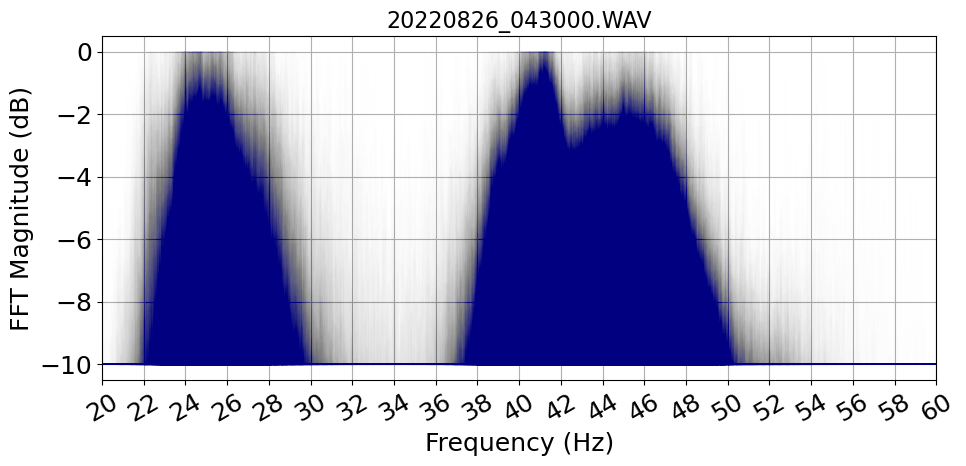

In [ ]:
plt.figure(figsize=(10, 5))
ft_size = 18
plt.title(f"{file_path.name}", fontsize=ft_size-2)
thresh = -10
line_color = 'navy'
line_alpha = 0.002

for i, row in selected_calls[::].iterrows():

    ########################################################################################################
    ############### BELOW WE READ IN THE WINDOW OF DETECTION OF THE AUDIO WE ARE CONSIDERING ###############
    ########################################################################################################

    start = row['start_time'] - 0.02
    end = row['start_time'] + 0.04
    duration = end - start
    audio_file.seek(int(fs*start))
    audio_seg = audio_file.read(int(fs*duration))

    ################################################################################################
    ############### BELOW WE APPLY A BANDPASS FILTER ON THE AUDIO WE ARE CONSIDERING ###############
    ################################################################################################

    nyq = 0.5 * fs
    low_cutoff = (row['low_freq'] - 2000)/ nyq
    high_cutoff =  (row['high_freq'] + 2000) / nyq
    b, a = scipy.signal.butter(5, [low_cutoff, high_cutoff], btype='band', analog=False)
    plot_audio_seg = scipy.signal.filtfilt(b, a, audio_seg)

    #####################################################################################
    ############### BELOW WE PLOT THE FFT OF THE AUDIO WE ARE CONSIDERING ###############
    #####################################################################################

    audio_spectrum = scipy.fft.rfft(plot_audio_seg)
    audio_spectrum_abs = np.abs(audio_spectrum)
    frequencies = np.arange(0, duration*fs/2)
    audio_spectrum_db =  20*np.log10(audio_spectrum_abs)
    normalized_audio_spectrum_db = audio_spectrum_db - audio_spectrum_db.max()

    thresh = -10
    peak_db = np.zeros(len(normalized_audio_spectrum_db))+thresh
    peak_db[normalized_audio_spectrum_db>=thresh] = normalized_audio_spectrum_db[normalized_audio_spectrum_db>=thresh]
    
    plt.plot(frequencies, peak_db, color=line_color, alpha=line_alpha)
    
plot_x_ticks = np.arange(0, duration*(fs/2), duration*2000)
plt.xticks(ticks=plot_x_ticks, labels=np.arange(0, fs/2000, 2, dtype='int'), rotation=30)
plt.xlim((20000)*duration, (60000)*duration)
plt.ylabel("FFT Magnitude (dB)")
plt.xlabel("Frequency (Hz)")
plt.grid(which='both')
plt.tight_layout()
plt.show()